# Main file for the project



ruben está editando este archivo.

#### A.Simule el comportamiento del aeropuerto durante un mes y estime las principales medidas de rendimiento del mismo 
**tiempos medios y máximos de espera de los aviones para aterrizar y despegar**
(tiempo medio y máximo de espera antes de entrar a N1)

**número medio de aviones en el aeropuerto**
(número de clientes en el sistema)


**% de tiempo que están ocupadas las pistas** 
(tiempo de ocupación de N1)


#### Variables propuestas

- t ≡ tiempo transcurrido de simulación 
- n1, n2, n3 ≡ nº de clientes en el nodo 1, 2 y 3 (var. de estado). 

- NLL1, NLL2, NLL3 ≡ nº de llegadas al primer, segundo y tercer nodo hasta el instante t (variables contador). 
- NS1, NS2, NS3 ≡ nº de salidas del primer, segundo y tercer nodo hasta el instante t (variables contador). 

- LISTA{tLL1, tS1, tS2, tS3} ≡ registro con cuatro elementos en los que guardamos los tiempos en que sucederán los cuatro tipos de eventos. 
- LLj(i), Sj(i) ≡ instante en el que llega/sale el cliente i-ésimo al/del servidor j-ésimo, j=1,2,3, respectivamente.

In [ ]:
import random

In [ ]:
def initialize_variables(lambda0):
    
    t = 0                   # Variable reloj. tiempo asíncrono.
    n1 = n2 = n3 = 0        # Variables de estado nº clientes
    NLL1 = NLL2 = NLL3 = 0  # Variables contador nº llegadas
    NS1 = NS2 = NS3 = 0     # Variables contador nº salidas
    
    # Lista de tiempos de eventos
    tLL1 = random.expovariate(lambda0)
    tS1 = float('inf')
    tS2 = float('inf')
    tS3 = float('inf')
    LISTA = [tLL1, tS1, tS2, tS3]
    
    # Arrays for arrival and departure times
    LL1 = []
    LL2 = []
    LL3 = []
    S1 = []
    S2 = []
    S3 = []
    
    return t, n1, n2, n3, NLL1, NLL2, NLL3, NS1, NS2, NS3, LISTA, LL1, LL2, LL3, S1, S2, S3

In [15]:
def getlambda0(t):
    # t está en minutos, convertir a horas:
    t = t/60
    # Intervalo de 0 a 5 horas, lineal de 5 a 7
    if 0 <= t < 5:
        return 5 + (7 - 5) * (t - 0) / (5 - 0)
    # Intervalo de 5 a 8 horas, lineal de 7 a 6
    elif 5 <= t < 8:
        return 7 + (6 - 7) * (t - 5) / (8 - 5)
    # Intervalo de 8 a 15 horas, lineal de 6 a 9
    elif 8 <= t < 15:
        return 6 + (9 - 6) * (t - 8) / (15 - 8)
    # Intervalo de 15 a 17 horas, lineal de 9 a 6
    elif 15 <= t < 17:
        return 9 + (6 - 9) * (t - 15) / (17 - 15)
    # Intervalo de 17 a 24 horas, lineal de 6 a 5
    elif 14 <= t <= 24:
        return 6 + (5 - 6) * (t - 17) / (24 - 17)
    # Si el tiempo está fuera del rango de 0 a 24 horas
    else:
        return None  


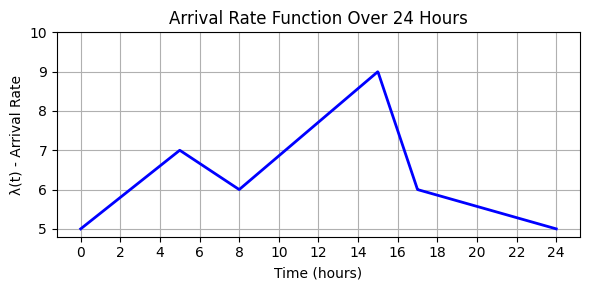

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Create time points array (0 to 24*60 minutes)
t = np.linspace(0, 24*60, 1000)

# Calculate lambda values for each time point
lambda_values = [getlambda0(ti) for ti in t]

# Create the plot
plt.figure(figsize=(6, 3))
plt.plot(t/60, lambda_values, 'b-', linewidth=2)
plt.grid(True)
plt.xlabel('Time (hours)')
plt.ylabel('λ(t) - Arrival Rate')
plt.title('Arrival Rate Function Over 24 Hours')
# Set x-axis ticks for every hour
plt.xticks(range(0, 25, 2))
plt.yticks(range(5, 11, 1))

plt.tight_layout()
plt.show()


In [23]:
def simul_main(T, lambda0, mu11, sigma11, a12, b12, lambda2, lambda3):
    # Initialize all variables using auxiliary function
    t, n1, n2, n3, NLL1, NLL2, NLL3, NS1, NS2, NS3, LISTA, LL1, LL2, LL3, S1, S2, S3 = initialize_variables(lambda0)
    
    # TODO
    while t < T:
        return LL1, S1, LL2, S2, LL3, S3

In [24]:
# ejemplo de uso

T = 24*60 # 24h en minutos
lambda0 = getlambda0
mu11 = 10
sigma11 = 3
a12 = 10
b12 = 15
lambda2 = 2
lambda3 = 0.1

simul_main(T, lambda0, mu11, sigma11, a12, b12, lambda2, lambda3)

NameError: name 'initialize_variables' is not defined